## overpass times and  orbital drift

This script outputs Extended data figures 7 and 8

Extended data figure 7 illustrates the average overpass time of each afternoon NOAA POES used in the study.

Extended data figure 8 examines the residual orbital drift of the curated AVHRR dataset. There are concerns about the influence of AVHRR orbital drift on fire signal. Following Giglio & Roy 2020, one way to investigate the extent of this issue is to examine the relationship between fire activity (annual count) and a measure of drift (in this case, 8-day average eq overpass time (doy >= 179 to doy <= 186), and to plot a hovmoller diagram.


In [1]:
import sys
import os
import glob
import csv
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def panel_scatter_plot(d, xvar, yvar, panelvar, xlab, ylab, nrow, ncol, dim = None, 
                       labelcol=None):
    """ 
    
    simple multipanel plotter 
      
    usage e.g.:
    
    panel_scatter_plot(d=terrestrial_sub2, 
                   xvar='val_count_1st', yvar='count_1st', panelvar='NAME_0', 
                   xlab='Terrestrial database annual fire count (1st differences)', 
                   ylab='AVHRR annual fire count (1st differences)', 
                   nrow=4, ncol=2)
    """
    
    if dim:
        pass
    else:
        dim=(8,12)
        
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol, 
                             squeeze=False, sharex=False, sharey=False, 
                             gridspec_kw=dict(hspace=0.4, wspace=0.5))
    axes = axes.flatten()
    
    statstable = pd.DataFrame({'region': [],                               
                               'tau':[],'p':[],'intercept': [],
                               'slope':[],'lower':[],'upper':[],
                              })

    #mpl.rcParams.update({'font.size': 10})
    for i, name in enumerate(np.unique(d[panelvar])):
        ax = axes[i]
        df = d[d[panelvar] == name]
        y = df[yvar].values
        x = df[xvar].values

        # calculate stats and collate
        #lr_m, lr_c, lr_r, lr_p, lr_se = stats.linregress(x=x, y=y)
        tau, tau_p = stats.kendalltau(x=x, y=y)
        ts_m, ts_c, ts_lower, ts_upper = stats.theilslopes(x=x, y=y, alpha=0.95)        
        #print(name,tau_p)
        #
        statstable.loc[len(statstable)] = [name,
                         round(tau,5), round(tau_p,5), round(ts_c,5), 
                         round(ts_m,5), round(ts_lower,5), round(ts_upper,5)]
        
        ax.scatter(x, y, marker='o', color='#cc4c02', s=12, alpha=0.8)
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        ax.plot(x, x * slope + intercept, 'k-')
        #labels
        ax.set_title(name)
        #lab = f'r={np.round(r_value, 2)}, p={np.round(p_value, 2)}\nr2={np.round(r_value**2, 2)}'
        lab      = ''.join(('r={0}, p={1}\n',r'$r^2$={2}')).format(np.round(r_value, 2),
                                                                 np.round(p_value, 2),
                                                                 np.round(r_value**2, 2))    
        plt.text(0.05, 0.7, lab, color='k', fontsize=8, transform = ax.transAxes)
        
        # make plots square
        ratio = 1.0
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        
        # tick label size
        ax.tick_params(axis='both', which='minor', labelsize=12)
        if labelcol:
            ax.set_title(df[labelcol].values[0], fontsize=10)
        else:
            ax.set_title(name, fontsize=10)

    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlab,fontsize=10, labelpad=15)
    plt.ylabel(ylab,fontsize=10, labelpad=15)   
    
    return fig, axes, statstable

# 1) overpass timeseries plot (Extended data Figure 7)

In [3]:
dir_base = Path(paths.dir_main)

dir_in = dir_base / "overpass_timing"
dir_out = dir_base / "outputs"

fn = "overpass_time_data_0lat0lon.csv"

In [4]:
df = pd.read_csv(str(dir_in / fn))

# split out some metadata from the file names
new = df["fn"].str.split(".", n = None, expand = True) 
df['sat'] = new[0]
df['doy'] = new[1]
df['start'] = new[2]
df['end'] = new[3]
df['block'] = new[4]
df['source'] = new[5]
df["doy2"] = (df["doy"].str.slice(-3)).astype(int)

# filter
list_valid_sats = ['NF','NH','NJ','NL','NN','NP']
df = df.loc[df.sat.isin(list_valid_sats)]

df.head()

,V1,fn,lat,lon,year,month,day,hour,time,satza,b1,b2,b3,b4,b5,sat,doy,start,end,block,source,doy2
13787,0,NF.D85060.S1313.E1458.B0111617.GC.nc,-0.007179,0.043500,1985,3,1,14.596787,3.207693e+08,27.193607,0.316712,0.288003,266.98022,233.38225,232.32846,NF,D85060,S1313,E1458,B0111617,GC,60
13788,0,NF.D85057.S0139.E0332.B0106768.WI.nc,-0.003746,0.012266,1985,2,26,2.375815,3.204662e+08,2.145160,0.001945,0.004226,287.32294,275.11667,271.05786,NF,D85057,S0139,E0332,B0106768,WI,57
13789,0,NF.D85057.S1346.E1530.B0107475.GC.nc,0.002464,0.046154,1985,2,26,15.130815,3.205121e+08,63.713330,0.118920,0.085920,294.87463,273.13528,268.50710,NF,D85057,S1346,E1530,B0107475,GC,57
13790,0,NF.D85058.S1333.E1519.B0108889.GC.nc,0.010628,0.003660,1985,2,27,14.952898,3.205978e+08,55.015118,0.108286,0.075170,298.89470,288.87155,287.04540,NF,D85058,S1333,E1519,B0108889,GC,58
13791,0,NF.D85058.S0128.E0321.B0108182.GC.nc,0.002808,0.043719,1985,2,27,2.197759,3.205519e+08,19.572270,0.001945,0.004226,296.40265,292.93936,290.93802,NF,D85058,S0128,E0321,B0108182,GC,58


### calculate mean overpass time for afternoon satellites' descending node
* get 8 day period in middle of each year and average the overpass time. 8 days is used as it appropriately samples the ground track repeat cycle of POES satellites, accounting for different local overpass times at different view angles
* Use the same middle of year 8 day period in each case to illustrate drift.

note: we are at 0 deg longitude, so no need to convert UTC here

In [5]:
df_am = df.loc[(df.hour < 12)]
df_am_stats = df_am.groupby(['sat','year']).hour.describe().reset_index()
df_am_stats.head()

,sat,year,count,mean,std,min,25%,50%,75%,max
0,NF,1985,243.0,2.468992,0.435727,1.470629,2.145189,2.466926,2.808870,3.390537
1,NF,1986,278.0,2.790126,0.467430,1.766023,2.432256,2.777169,3.154183,3.851856
2,NF,1987,295.0,3.313451,0.480776,2.210699,2.945888,3.309224,3.666864,4.383564
3,NF,1988,262.0,3.846574,0.466202,2.838252,3.489099,3.850720,4.196884,4.960923
4,NH,1988,46.0,1.661588,0.460269,0.748333,1.288263,1.649999,2.050729,2.431666


add a flag to indicate which years are used in analysis

In [6]:
df_am_stats['sat_yr'] = df_am_stats.sat + (df_am_stats.year).astype(str)

list_narrow = [          'NF1986',
               'NH1989', 'NH1990', 'NH1991',
               'NJ1996', 'NJ1997', 'NJ1998',
               'NL2001', 'NL2002', 'NL2003', 'NL2004', 'NL2005',
               'NN2006', 'NN2007', 'NN2008', 'NN2009', 'NN2010', 'NN2011', 'NN2012',
               'NP2013', 'NP2014', 'NP2015', 'NP2016']

df_am_stats['valid'] = 0
df_am_stats.loc[df_am_stats['sat_yr'].isin(list_narrow), 'valid'] = 1

plot the relationships

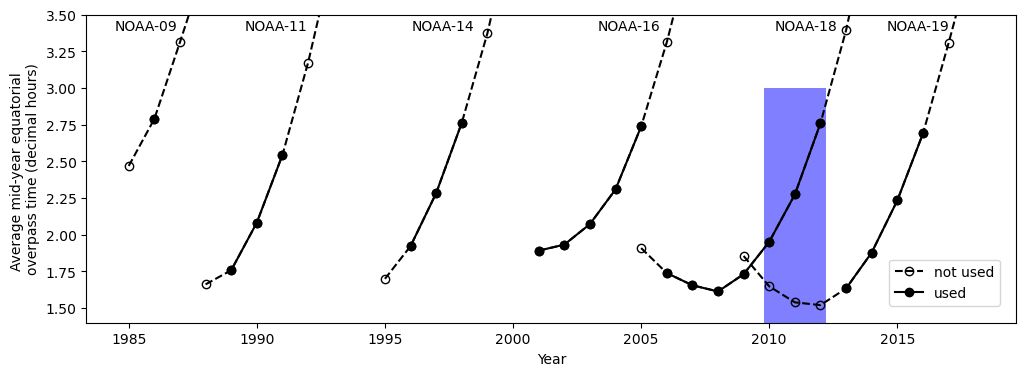

In [7]:
list_valid_sats = ['NF','NH','NJ','NL','NN','NP']

fig, axes = plt.subplots(figsize=(12,4), nrows=1, ncols=1, gridspec_kw=dict(hspace=0.4))
ax = axes
rect = mpl.patches.Rectangle((2009.8, 0), width=2.4, height=3, facecolor='blue', alpha=0.5, edgecolor=None)
ax.add_patch(rect)                      
for i, sat in enumerate(list_valid_sats):
    sub         = df_am_stats.loc[df_am_stats.sat == sat]
    sub_valid   = df_am_stats.loc[(df_am_stats.sat == sat) & (df_am_stats.valid == 1)]
    sub_avg     = df_am_stats.loc[(df_am_stats.year >= 2010) & (df_am_stats.year <= 2012)]
    years       = sub.year.values
    hour        = sub['mean'].values
    years_valid = sub_valid.year.values
    hour_valid  = sub_valid['mean'].values
    years_avg   = sub_avg.year.values
    hour_avg    = sub_avg['mean'].values
    
    ax.plot(years, hour, marker='o', ls='--', color = 'k', fillstyle='none', label='not used')
    ax.plot(years_valid, hour_valid, marker='o', ls='-', color = 'k', fillstyle='full', label='used')

ax.set_ylim(1.4, 3.5)
plt.ylabel("Average mid-year equatorial \noverpass time (decimal hours)")
plt.xlabel("Year")

plt.text(0.03, 0.95, 'NOAA-09', color='k', fontsize=10, transform = ax.transAxes)
plt.text(0.17, 0.95, 'NOAA-11', color='k', fontsize=10, transform = ax.transAxes)
plt.text(0.35, 0.95, 'NOAA-14', color='k', fontsize=10, transform = ax.transAxes)
plt.text(0.55, 0.95, 'NOAA-16', color='k', fontsize=10, transform = ax.transAxes)
plt.text(0.74, 0.95, 'NOAA-18', color='k', fontsize=10, transform = ax.transAxes)
plt.text(0.86, 0.95, 'NOAA-19', color='k', fontsize=10, transform = ax.transAxes)

# make universal legend
handles, labels = ax.get_legend_handles_labels()  
leg = fig.legend(handles[0:2], labels[0:2], loc='center', bbox_to_anchor=[0.84, 0.21])
fig.savefig(str(dir_out / 's7_overpass_timeseries.png'), dpi=800)
fig.savefig(str(dir_out / 's7_overpass_timeseries.pdf'))

# 2) annual fire counts vs overpass time (Extended Data Figure 8a)
* take the annual mid-year overpass times from the previous analysis and plot against the corresponding annual fire counts for each satellite and region. 

In [8]:
# load AVHRR raw data by GFED region (not using the gfed regionality file here, need NN and NP options)
fn_av_raw = dir_base / "avhrr_hotspots_masked.csv"

av_raw = pd.read_csv(fn_av_raw)
av_raw = av_raw.loc[av_raw.gfed_name != 'Mask']
# filter relevant satellites/years
av_raw['sat_yr'] = av_raw['sat'] + av_raw['year'].astype('str')
av_raw = av_raw[av_raw['sat_yr'].isin(list_narrow)]
print(np.unique(av_raw.sat_yr))

# aggregate to yearly
av_year = av_raw[['sat_yr','sat','year','gfed','gfed_name','doy']]\
    .groupby(['sat_yr','sat','year','gfed','gfed_name'])\
    .agg(['count'])\
    .droplevel(0, axis=1)\
    .reset_index()
av_year.head()

# add global totals
av_year_globe = av_raw[['sat_yr','sat','year','doy']]\
    .groupby(['sat_yr','sat','year',])\
    .agg(['count'])\
    .droplevel(0, axis=1)\
    .reset_index()
av_year_globe['gfed'] = 99
av_year_globe['gfed_name'] = 'global'

av_year = pd.concat([av_year, av_year_globe])

# add the 'lat/lon 0,0' time data from the previous overpass time analysis and combine by sat and year.
# note: NO region specificity here - doesn't matter where equator crossing is for this analysis.
df = av_year.merge(df_am_stats[['sat','year','mean']], how='left', on=['sat','year'])

# only keep the older NN satellite for the NN/NP overlap period
df = df.loc[(df.sat_yr != 'NP2010') & (df.sat_yr != 'NP2011') & (df.sat_yr != 'NP2012')]

['NF1986' 'NH1989' 'NH1990' 'NH1991' 'NJ1996' 'NJ1997' 'NJ1998' 'NL2001'
 'NL2002' 'NL2003' 'NL2004' 'NL2005' 'NN2006' 'NN2007' 'NN2008' 'NN2009'
 'NN2010' 'NN2011' 'NN2012' 'NP2013' 'NP2014' 'NP2015' 'NP2016']


In [9]:
# make more readable
df['gfed_full_name'] = ''
df.loc[df.gfed_name=='BONA', 'gfed_full_name'] = 'Boreal North \nAmerica (BONA)'
df.loc[df.gfed_name=='TENA', 'gfed_full_name'] = 'Temperate North \nAmerica (TENA)'
df.loc[df.gfed_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
df.loc[df.gfed_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere \nSouth America (NHSA)'
df.loc[df.gfed_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere \nSouth America (SHSA)'
df.loc[df.gfed_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
df.loc[df.gfed_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
df.loc[df.gfed_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere \nAfrica (NHAF)'
df.loc[df.gfed_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere \nAfrica (SHAF)'
df.loc[df.gfed_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
df.loc[df.gfed_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
df.loc[df.gfed_name=='SEAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
df.loc[df.gfed_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
df.loc[df.gfed_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
df.loc[df.gfed_name=='global', 'gfed_full_name'] = 'Global'
df.head()

,sat_yr,sat,year,gfed,gfed_name,count,mean,gfed_full_name
0,NF1986,NF,1986,1,BONA,237,2.790126,Boreal North \nAmerica (BONA)
1,NF1986,NF,1986,2,TENA,597,2.790126,Temperate North \nAmerica (TENA)
2,NF1986,NF,1986,3,CEAM,637,2.790126,Central America (CEAM)
3,NF1986,NF,1986,4,NHSA,287,2.790126,Northern Hemisphere \nSouth America (NHSA)
4,NF1986,NF,1986,5,SHSA,3224,2.790126,Southern Hemisphere \nSouth America (SHSA)


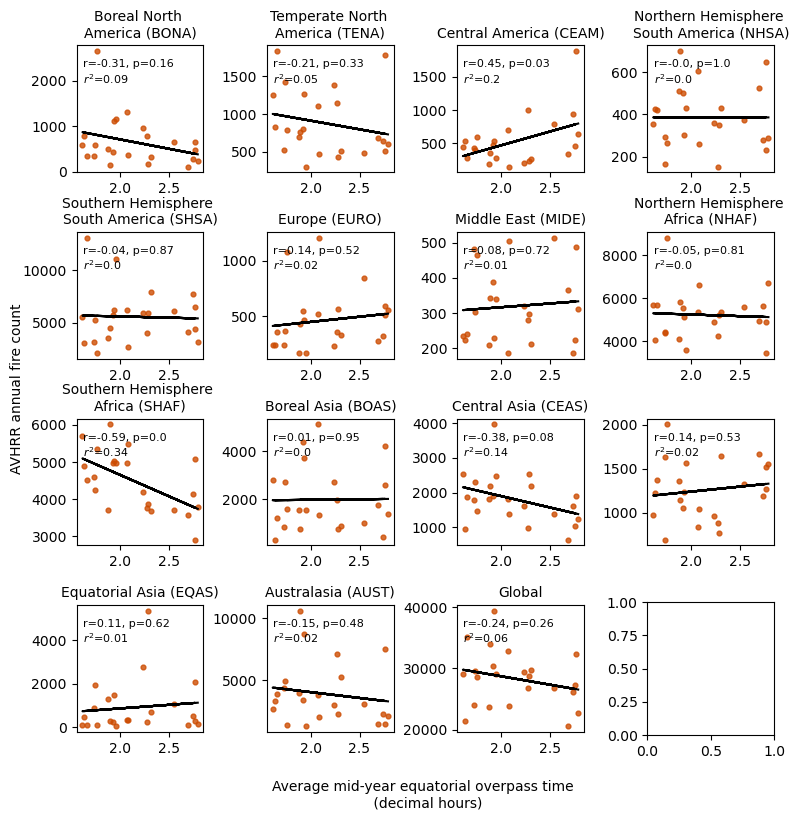

In [10]:
#from scipy import stats
fig, axes, summary = panel_scatter_plot(d=df, 
                                        xvar='mean', 
                                        yvar='count', panelvar='gfed', 
                                        xlab="Average mid-year equatorial overpass time \n (decimal hours)", 
                                        ylab="AVHRR annual fire count", 
                                        nrow=4, ncol=4, dim=(9,9),labelcol='gfed_full_name')
#fig.delaxes(axes[-1])
fig.savefig(str(dir_out / 's8a_orbit_time_vs_fire_count.png'), dpi=800)
fig.savefig(str(dir_out / 's8a_orbit_time_vs_fire_count.pdf'))

# 3) Hovmoller plot (Extended Data Figure 8b)
* Latitudinal anomaly (zscore) relative to 2001-16 period, following the Giglio & Roy 2020 Figure 5.

In [11]:
# reload the raw hotspot data and aggregate by degree of latitude
df = pd.read_csv(str(dir_base / "avhrr_hotspots_masked.csv"))

#edit some fields and filter for relevant satellites/years
df['date_lst'] = pd.to_datetime(df['date_lst'])
df['sat_yr'] = df['sat'] + df['year'].astype('str')
df = df[df['sat_yr'].isin(list_narrow)]

# only need a few columns for this
df = df[['lat', 'year', 'month']]
df['latrnd'] = np.round(df['lat'],0).astype(int)

* Generate monthly timeseries of fire counts by degree of latitude
* expand zeros
* make climatology (mean and std) for 2001-2016 per 1 degree of latitude, for calculating zscores as in Giglio & Roy (2020)
* calculate anomaly from climatology using z-scores: (x-mean) / std

In [12]:
# Generate monthly timeseries======
df_counts = df.groupby(['latrnd', 'year', 'month']).agg(fire_count=('lat','count')).reset_index()

# expand the timeseries so that all months with no fire observations have zero values
a = df_counts[['year']].drop_duplicates().reset_index(drop=True)     # n = 23
b = df_counts[['month']].drop_duplicates().reset_index(drop=True)    # n= 12
bb = df_counts[['latrnd']].drop_duplicates().reset_index(drop=True)  # n= 126 (-55 to +70)
a['joincol'] = 1
b['joincol'] = 1
bb['joincol'] = 1
c = bb.merge(a, how='outer', on='joincol')
c = c.merge(b, how='outer', on='joincol')
c = c.drop(['joincol'], axis=1).sort_values(['year', 'month'], ascending=True)
c['dummy'] = 0
c
print(f'expanded shape = {np.shape(c)[0]}, should be = 32016 (23*12*116)')

print(f'shape before expansion: {df_counts.shape}')
df_counts = df_counts.merge(c, how='outer', on=['latrnd', 'year', 'month'])
df_counts.loc[np.isnan(df_counts['fire_count']), 'fire_count'] = 0
df_counts = df_counts.drop(['dummy'], axis=1)
print(f'shape after expansion: {df_counts.shape}')

# generate climatology=======
# std = NaN if only one data point
# std = zero if all fire counts are the same
df_clim = df_counts.loc[(df_counts.year > 2000)]\
           .groupby(['latrnd','month'])\
           .agg(fire_mean=('fire_count','mean'), 
                fire_std=('fire_count','std')).reset_index()

# merge the clim statistics with the timeseries, then calculate z-score anom
print(df_counts.shape)
df_counts = df_counts.merge(df_clim, on=['latrnd','month'], how='left')
# calculate the z-scores
df_counts['fire_anom'] = (df_counts.fire_count - df_counts.fire_mean) / df_counts.fire_std
# set inf = NaN
df_counts.loc[np.isinf(df_counts.fire_anom), 'fire_anom'] = np.nan
#print('np.max(df_counts.fire_anom):', np.max(df_counts.fire_anom))
print(df_counts.shape)

# add indices for gridding by lat (y axis) and month (x axis)
# offset lat by 90 so all values are positive
df_clim['lat_ix'] = np.abs(df_clim.latrnd + 90)
df_counts['lat_ix'] = np.abs(df_counts.latrnd + 90)
# month index is simple, but getting month_ix for df_counts is a bit more complex
df_clim['month_ix'] = np.abs(df_clim.month - 1)
df_months = pd.DataFrame({'dt': pd.date_range(start='19860101', end='20170101', freq='ME')})
df_months['year'] = df_months['dt'].dt.year
df_months['month'] = df_months['dt'].dt.month
df_months = df_months.reset_index().rename(columns={'index':'month_ix'})
df_counts = df_counts.merge(df_months[['year','month','month_ix']], on=['year','month'], how='left')
print(df_counts.shape)

# temporarily replace any zero values with "-9999"
# hist binning process introduces zeros where no data fall in bins - 
# need to distinguish these from valid zero values in statistics
df_clim.loc[df_clim['fire_mean']==0, 'fire_mean'] = -9999        
df_clim.loc[df_clim['fire_std']==0, 'fire_std'] = -9999          
df_counts.loc[df_counts['fire_count']==0, 'fire_count'] = -9999  
df_counts.loc[df_counts['fire_mean']==0, 'fire_mean'] = -9999    
df_counts.loc[df_counts['fire_std']==0, 'fire_std'] = -9999      
df_counts.loc[df_counts['fire_anom']==0, 'fire_anom'] = -9999    

expanded shape = 32016, should be = 32016 (23*12*116)
shape before expansion: (24184, 4)
shape after expansion: (32016, 4)
(32016, 4)
(32016, 7)
(32016, 9)


grid (and plot) the climatology mean/std values

mean minmax: 0.0 340.875 has nans: True
std minmax: 0.0 276.16111692271227 has nans: True
bin minmax: 1.0 1.0 has nans: True


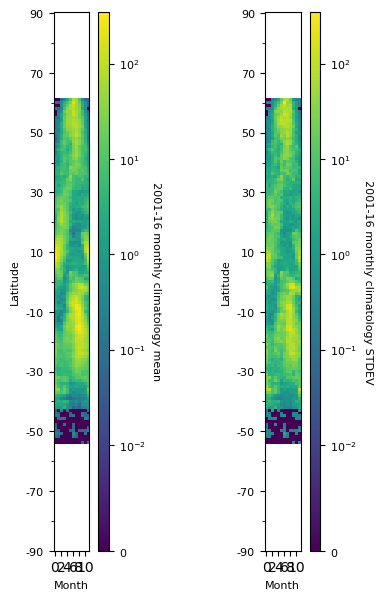

In [13]:
# define grid res and some tick params
res = 1
yint = 20
yintmin = 10
xint = 24
xintmin = 12

# bins
ybin = np.linspace(0., 180., num=int(180 / res) + 1) #lat
xbin = np.linspace(0., 12., num=int(12 / res) + 1)   #months

mean_grid, _, _ = np.histogram2d(x=df_clim['month_ix'].values, y=df_clim['lat_ix'].values,
                          bins=[xbin, ybin],
                          weights=df_clim['fire_mean'].values)
std_grid, _, _ = np.histogram2d(x=df_clim['month_ix'].values, y=df_clim['lat_ix'].values,
                          bins=[xbin, ybin],
                          weights=df_clim['fire_std'].values)
bin_grid, _, _ = np.histogram2d(x=df_clim['month_ix'].values, y=df_clim['lat_ix'].values,
                          bins=[xbin, ybin],
                          weights=None)

# need to both rotate and flip to orient N-S correctly!
mean_grid = np.rot90(mean_grid)
std_grid = np.rot90(std_grid)
bin_grid = np.rot90(bin_grid)

# fix zeros/NaNs
# set all zeros introduced in gridding to NaN
mean_grid[mean_grid == 0] = np.nan
std_grid[std_grid == 0] = np.nan
bin_grid[bin_grid == 0] = np.nan
# set all true zeros (-9999) back to zero
mean_grid[mean_grid == -9999] = 0
std_grid[std_grid == -9999] = 0
bin_grid[bin_grid == -9999] = 0

print('mean minmax:',   np.nanmin(mean_grid), np.nanmax(mean_grid),f'has nans: {np.isnan(np.sum(mean_grid))}')
print('std minmax:',    np.nanmin(std_grid), np.nanmax(std_grid),f'has nans: {np.isnan(np.sum(std_grid))}')
print('bin minmax:',    np.nanmin(bin_grid), np.nanmax(bin_grid),f'has nans: {np.isnan(np.sum(bin_grid))}')

#
yticks = np.arange(0, 180 + 1, yint)
yticks_minor = np.arange(0, 180 + 1, yintmin)
ylabs = np.flipud(np.arange(-90, 90 + 1, yint))

fig, axes = plt.subplots(figsize=(5,7), nrows=1, ncols=2,
                       #gridspec_kw=dict(hspace=0.4, wspace=0.5)
                         )
axes=axes.flatten()

## MEAN PLOT
ax=axes[0]
im = ax.matshow(mean_grid,cmap='viridis', norm=mpl.colors.SymLogNorm(linthresh=0.01, vmin=0, vmax=350))#cmap='hot_r'
cb = utils.colorbar_v4(fig=fig, ax=ax, mesh=im, fontsize=8, #cbar_scale=0.5, 
                 ticks=None, ticklab=None,cblab='2001-16 monthly climatology mean', 
                 cb_options={'extend': 'neither'})
cb.ax.tick_params(labelsize=8)
# plot aesthetics
ax.set_xlabel('Month', fontsize=8)
ax.set_ylabel('Latitude', fontsize=8)

ax.set_yticks(yticks)
ax.set_yticks(yticks_minor, minor=True)
ax.set_yticklabels(ylabs, fontsize=8)
ax.xaxis.set_ticks_position('bottom')   # adjust the imshow default


# STDEV PLOT
ax=axes[1]
im = ax.matshow(std_grid,cmap='viridis', norm=mpl.colors.SymLogNorm(linthresh=0.01, vmin=0, vmax=350)) #cmap='winter'
cb = utils.colorbar_v4(fig=fig, ax=ax, mesh=im, fontsize=8, #cbar_scale=0.5, 
                 ticks=None, ticklab=None, cblab='2001-16 monthly climatology STDEV', 
                 cb_options={'extend': 'neither'})
cb.ax.tick_params(labelsize=8)
# plot aesthetics
ax.set_xlabel('Month', fontsize=8)
ax.set_ylabel('Latitude', fontsize=8)
ax.set_yticks(yticks)
ax.set_yticks(yticks_minor, minor=True)
ax.set_yticklabels(ylabs, fontsize=8)
ax.xaxis.set_ticks_position('bottom')   # adjust the imshow default

In [14]:
# BIN THE FULL MONTHLY TIMESERIES
# define grid res
res = 1

# bins
# x = 31 years * 12 months = 372 
# y = 180
ybin = np.linspace(0., 180., num=int(180 / res) + 1) #lat
xbin = np.linspace(0., 372., num=int(372 / res) + 1)   #months

anom_grid, _, _ = np.histogram2d(x=df_counts['month_ix'].values, 
                                 y=df_counts['lat_ix'].values,
                                  bins=[xbin, ybin],
                                  weights=df_counts['fire_anom'].values)

# need to rotate to orient N-S correctly!
anom_grid = np.rot90(anom_grid)


print('anom minmax:',   np.nanmin(anom_grid), np.nanmax(anom_grid), f'has nans: {np.isnan(np.sum(anom_grid))}')

# fix zeros/NaNs
# set all zeros introduced in gridding to NaN
anom_grid[anom_grid == 0] = np.nan
# set all true zeros (-9999) back to zero
anom_grid[anom_grid == -9999] = 0

print('anom minmax:',   np.nanmin(anom_grid), np.nanmax(anom_grid), f'has nans: {np.isnan(np.sum(anom_grid))}')

anom minmax: -9999.0 214.83922595390854 has nans: True
anom minmax: -3.1475559167092744 214.83922595390854 has nans: True


finally, make the Hovmoller plot for the full timeseries

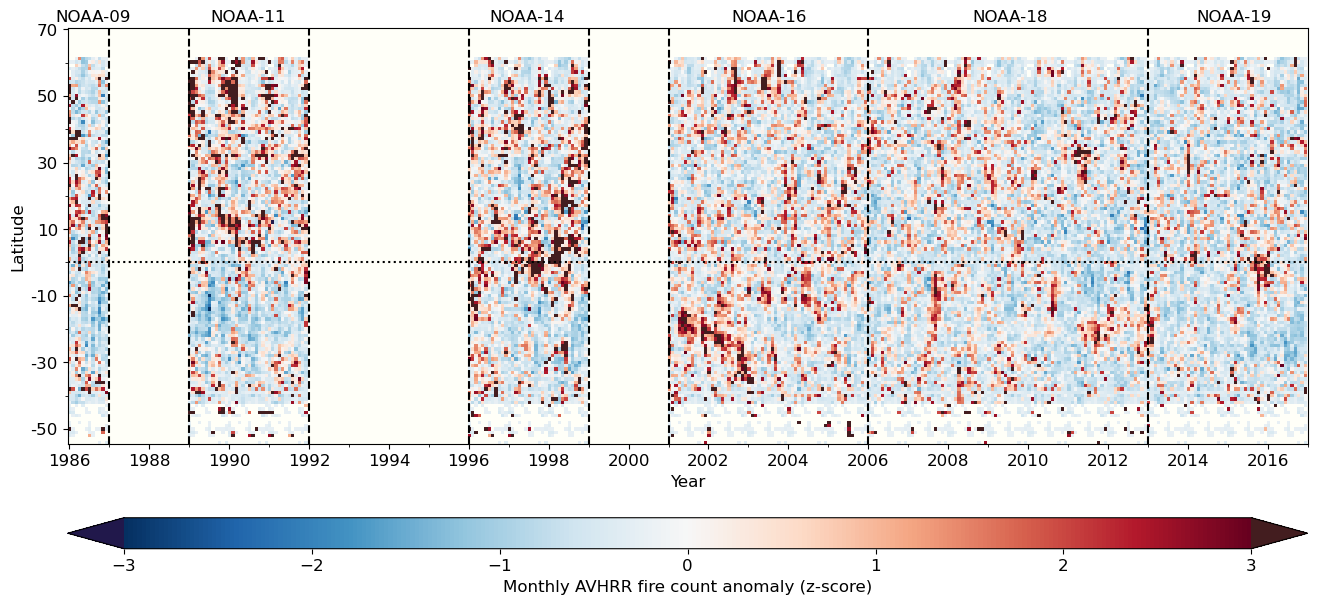

In [15]:
yint = 20
yintmin = 10
xint = 24
xintmin = 12

yticks = np.arange(0, 120 + 1, yint)
yticks_minor = np.arange(0, 120 + 1, yintmin)
ylabs = np.flipud(np.arange(-50, 70 + 1, yint))

# my range
xticks = np.arange(0, 372 + 1, xint)
xticks_minor = np.arange(0, 372 + 1, xintmin)
xlabs = np.arange(1986, 2016 + 1, 2)

cmap = plt.cm.RdBu_r
cmap.set_over('#431d1f')
cmap.set_under('#21184b')
cmap.set_bad(color='xkcd:off white')
cmap.set_bad(color='#fcfce7')
cmap.set_bad(color='#fffff8')
#cmap.set_bad(color='magenta')

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=1,
                       gridspec_kw=dict(hspace=0.4, wspace=0.5))
im  = ax.matshow(anom_grid[20:145], cmap=cmap, interpolation=None, vmin=-3,vmax=3)

utils.colorbar_v4(fig, ax, im, cblab="Monthly AVHRR fire count anomaly (z-score)", fontsize=12,
                  cbax_options={'location': 'bottom', 'pad': 0.12, 'shrink': 1, 'aspect': 40}, 
                  cb_options={'orientation': 'horizontal', 'extend': 'both'})

# plot aesthetics
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

ax.set_xticks(xticks)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabs, fontsize=12)
ax.set_yticks(yticks)
ax.set_yticks(yticks_minor, minor=True)
ax.set_yticklabels(ylabs, fontsize=12)
ax.xaxis.set_ticks_position('bottom')   # adjust the imshow default

ax.axhline(y=70, xmin=0, xmax=1, color='k', linestyle=':')

ax.axvline(x=12, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=36, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=72, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=120, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=156, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=180, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=240, ymin=0, ymax=1, color='k', linestyle='--')
ax.axvline(x=324, ymin=0, ymax=1, color='k', linestyle='--')

plt.text(-0.01, 1.015, 'NOAA-09', color='k', fontsize=12, transform = ax.transAxes)
plt.text(0.115, 1.015, 'NOAA-11', color='k', fontsize=12, transform = ax.transAxes)
plt.text(0.34, 1.015, 'NOAA-14', color='k', fontsize=12, transform = ax.transAxes)
plt.text(0.535, 1.015, 'NOAA-16', color='k', fontsize=12, transform = ax.transAxes)
plt.text(0.73, 1.015, 'NOAA-18', color='k', fontsize=12, transform = ax.transAxes)
plt.text(0.91, 1.015, 'NOAA-19', color='k', fontsize=12, transform = ax.transAxes)

fig.savefig(str(dir_out / 's08b_hovmoller_plot.png'), dpi=800)
fig.savefig(str(dir_out / 's08b_hovmoller_plot.pdf'))